In [1]:
#%matplotlib notebook
#from matplotlib import style
#style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [41]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, desc

In [42]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [43]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [44]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [45]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [46]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

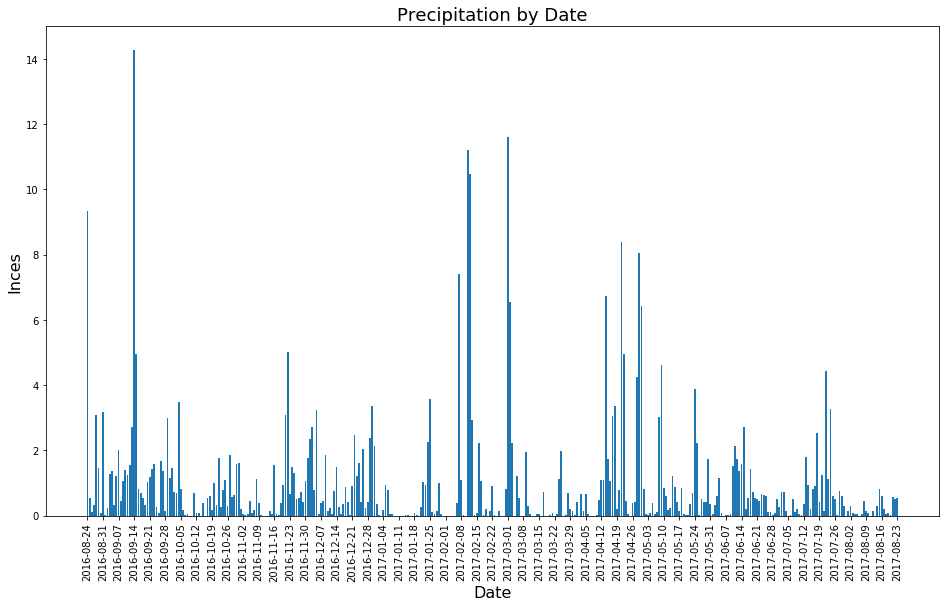

In [47]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from today
today_str = session.query(func.max(Measurement.date)).first()[0]
today = dt.datetime.strptime(today_str, '%Y-%m-%d').date()
today_1y = today - dt.timedelta(days=365.25)

# Perform a query to retrieve the data and precipitation scores
precipitation = session.query(Measurement).filter(Measurement.date > today_1y).filter(Measurement.date <= today)

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.read_sql(precipitation.statement, session.bind)
df_prec = df.groupby('date').sum()

# Sort the dataframe by date
df_prec = df_prec.sort_index()

# Use Pandas Plotting with Matplotlib to plot the data
fig = plt.figure(figsize = (16,9))
ax = plt.axes()

b1 = np.array(df_prec['prcp'])
ax.bar(df_prec.index, b1)

# Set plot features and font size
ax.set_title('Precipitation by Date', fontsize = 18)
ax.set_ylabel('Inches', fontsize = 16)
ax.set_xlabel('Date', fontsize = 16)

# Space ticks and labels to be every 3rd, label text rotated 90 degrees
ax.set_xticks(ax.get_xticks()[::7])
ax.set_xticklabels(labels = df_prec.index.values[::7], rotation = 90)

plt.show()

In [48]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df_prec.describe()

,id,prcp,tobs
count,365.000000,365.000000,365.000000
mean,61874.904110,0.974164,454.216438
std,9186.077171,1.776466,72.501836
min,29871.000000,0.000000,232.000000
25%,58190.000000,0.050000,414.000000
50%,62010.000000,0.400000,461.000000
75%,69996.000000,1.080000,514.000000
max,71404.000000,14.280000,557.000000


In [49]:
# How many stations are available in this dataset?
stations = session.query(func.count(Station.station)).all()[0][0]
stations

9

In [59]:
# What are the most active stations?
# List the stations and the counts in descending order.
act_station = session.query(Measurement.station, func.count(Measurement.prcp)).\
    group_by(Measurement.station).\
    order_by(desc(func.count(Measurement.prcp))).all()

for state in act_station:
    print(state)

('USC00519281', 2772)
('USC00513117', 2696)
('USC00519397', 2685)
('USC00519523', 2572)
('USC00516128', 2484)
('USC00514830', 1937)
('USC00511918', 1932)
('USC00517948', 683)
('USC00518838', 342)


In [60]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
station_ma_id = session.query(Measurement.station, func.count(Measurement.prcp)).\
    group_by(Measurement.station).\
    order_by(desc(func.count(Measurement.prcp))).\
    first()

sel = [Measurement.station, func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)]
ma_station = session.query(*sel).filter(Measurement.station == station_ma_id[0]).all()

ma_station

[('USC00519281', 54.0, 85.0, 71.66378066378067)]

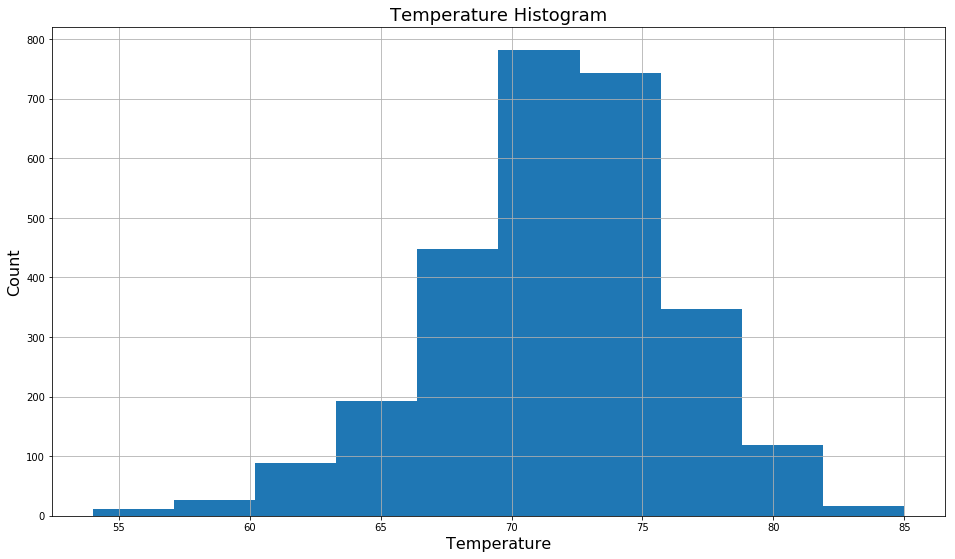

In [78]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
station_to_id = session.query(Measurement.station, func.count(Measurement.tobs)).\
    group_by(Measurement.station).\
    order_by(desc(func.count(Measurement.tobs))).\
    first()

sel = [Measurement.station, Measurement.tobs]
temperature = session.query(*sel).filter(Measurement.station == station_to_id[0])

df2 = pd.read_sql(temperature.statement, session.bind)

# Sort the dataframe by date
df_temp = df2.sort_index()

# # Use Pandas Plotting with Matplotlib to plot the data
fig2 = plt.figure(figsize = (16,9))
ax2 = plt.axes()

ax2.hist(df_temp['tobs'])

# Set plot features and font size
ax2.set_title('Temperature Histogram', fontsize = 18)
ax2.set_ylabel('Count', fontsize = 16)
ax2.set_xlabel('Temperature', fontsize = 16)
ax2.grid(True)

In [79]:
# Write a function called `calc_temps` that will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
   
    start_date = dt.datetime.strptime(start_date, '%Y-%m-%d').date()
    end_date = dt.datetime.strptime(end_date, '%Y-%m-%d').date()
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [123]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
vacay = calc_temps('2016-06-01', '2016-06-15')
print(calc_temps('2016-06-01', '2016-06-15'))
vacay[0][2]

[(64.0, 74.15625, 81.0)]


81.0

(0.5, 1.5)

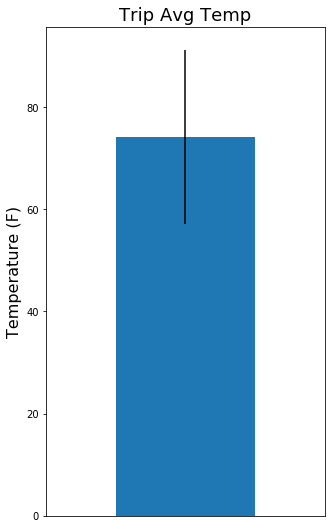

In [125]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

# Use Pandas Plotting with Matplotlib to plot the data
fig3 = plt.figure(figsize = (5,9))
ax3 = plt.axes()

ax3.bar(x = [1], height = vacay[0][1], width = 0.5, yerr = [vacay[0][2]-vacay[0][0]])

# Set plot features and font size
ax3.set_title('Trip Avg Temp', fontsize = 18)
ax3.set_ylabel('Temperature (F)', fontsize = 16)
ax3.set_xticks([])
ax3.set_xlim(0.5, 1.5)

In [146]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

trip_precip = session.query(Measurement).filter(Measurement.date > dt.datetime.strptime('2016-06-01', '%Y-%m-%d').\
    date()).filter(Measurement.date <= dt.datetime.strptime('2016-06-15', '%Y-%m-%d').date())

stat_meta = session.query(Station)

sel = [Measurement.station, Station.name, func.sum(Measurement.prcp).label('prec_tot'), Station.latitude, Station.longitude, Station.elevation]
comb = session.query(*sel).filter(Measurement.station == Station.station).group_by(Measurement.station).order_by(desc('prec_tot'))

trip_df = pd.read_sql(comb.statement, session.bind)
trip_df

,station,name,prec_tot,latitude,longitude,elevation
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",1068.09,21.33310,-157.80250,152.4
1,USC00519281,"WAIHEE 837.5, HI US",588.64,21.45167,-157.84889,32.9
2,USC00513117,"KANEOHE 838.1, HI US",382.62,21.42340,-157.80150,14.6
3,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",295.68,21.33556,-157.71139,19.5
4,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",234.49,21.52130,-157.83740,7.0
5,USC00519397,"WAIKIKI 717.2, HI US",131.62,21.27160,-157.81680,3.0
6,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",92.68,21.31520,-157.99920,0.9
7,USC00518838,"UPPER WAHIAWA 874.3, HI US",70.87,21.49920,-158.01110,306.6
8,USC00517948,"PEARL CITY, HI US",43.44,21.39340,-157.97510,11.9


## Optional Challenge Assignment

In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
